In [112]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchinfo
import torchtext.transforms as T
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils.data import DataLoader
from torchlake.text_classification.models import TextCnn
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from tqdm import tqdm

# setting


In [113]:
data_path = Path("../../data/childrenBooksAndStories")
artifacts_path = Path("../../artifacts/textcnn")

In [114]:
unk_idex = 0
bos_idx = 1
eos_idx = 2
padding_idx = 3
min_seq_len = 5
max_seq_len = 256

In [115]:
batch_size = 32
min_frequency = 5

In [116]:
tokenizer = get_tokenizer("basic_english")

In [117]:
data = pd.read_csv(
    data_path.joinpath("children_stories.csv").as_posix(),
    encoding="latin-1",
    usecols=["cats", "desc"],
)

In [118]:
# 移除空標籤
data = data.query('cats != "Age "')

In [119]:
def convert_label(label: str) -> int:
    """convert age label to label

    Args:
        label (str): age label, in format like 'x-y', 'x+'

    Returns:
        int: 0 -> before kindergarten, 1 -> kindergarten, 2 -> elementary school
    """

    label = label.replace("6months", "0.5")

    if "-" in label:
        [lower, upper] = label.split("-")
        lower, upper = float(lower), float(upper)
    else:
        lower = float(label.replace("+", ""))
        upper = np.Inf

    if 3 >= lower:
        return 1
    elif 8 >= lower:
        return 2
    else:
        return 0

In [120]:
data["cats"] = data.cats.str.replace("Age\s", "", regex=True)

In [121]:
data["cats"] = data.cats.apply(convert_label)

In [122]:
data.cats.value_counts()

cats
1    179
2    146
0    103
Name: count, dtype: int64

In [123]:
train_data, test_data = train_test_split(data, test_size=1 / 5)

In [124]:
vocab = build_vocab_from_iterator(
    train_data["desc"].str.split(),
    specials=["<unk>", "<bos>", "<eos>", "<pad>"],
    min_freq=min_frequency,
)

vocab.set_default_index(vocab["<unk>"])

In [125]:
text_transform = T.Sequential(
    T.VocabTransform(vocab),
    T.Truncate(max_seq_len - 2),
    T.AddToken(token=bos_idx, begin=True),
    T.AddToken(token=eos_idx, begin=False),
    T.ToTensor(),
    T.PadTransform(max_seq_len, padding_idx),
)

In [126]:
def collate_fn(batch: np.ndarray):
    text_placeholder, label_placeholder = [], []

    for label, text in batch:
        text = tokenizer(text)
        text = text_transform(text)
        text_placeholder.append(text)
        label_placeholder.append(label)

    return torch.stack(text_placeholder), torch.Tensor(label_placeholder)

In [127]:
train_iter = DataLoader(
    train_data.to_numpy(),
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=True,
)

test_iter = DataLoader(
    test_data.to_numpy(),
    batch_size=batch_size,
    collate_fn=collate_fn,
)

In [128]:
for text, label in train_iter:
    print(text.shape, label.shape)
    break

torch.Size([32, 256]) torch.Size([32])


# model


In [129]:
vocab_size = len(vocab)
label_size = data.cats.nunique()

In [130]:
device = torch.device("cuda:0")

In [131]:
model = TextCnn(vocab_size, 32, label_size, padding_idx=padding_idx).to(device)

In [132]:
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
TextCnn                                  --
├─Embedding: 1-1                         29,472
├─TextCnnPool: 1-2                       --
│    └─ModuleList: 2-1                   --
│    │    └─Sequential: 3-1              2,080
│    │    └─Sequential: 3-2              3,104
│    │    └─Sequential: 3-3              4,128
├─Linear: 1-3                            291
Total params: 39,075
Trainable params: 39,075
Non-trainable params: 0

# train


In [133]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [134]:
epoches = 20

In [135]:
model.train()
training_loss = []
for e in range(epoches):
    running_loss = 0.0

    for text, label in tqdm(train_iter):
        optimizer.zero_grad()

        text = text.to(device)
        label = label.to(device)

        output = model(text)

        loss = criterion(output, label.long())
        running_loss += loss.item()

        loss.backward()
        optimizer.step()

    training_loss.append(running_loss / len(train_data))

    print(f"epoch {e+1} : {running_loss / len(train_data)}")

100%|██████████| 11/11 [00:00<00:00, 38.80it/s]


epoch 1 : 0.034994194382115415


100%|██████████| 11/11 [00:00<00:00, 87.66it/s]


epoch 2 : 0.032127796035063896


100%|██████████| 11/11 [00:00<00:00, 73.69it/s]


epoch 3 : 0.030167513249213237


100%|██████████| 11/11 [00:00<00:00, 94.80it/s]


epoch 4 : 0.02875713333051804


100%|██████████| 11/11 [00:00<00:00, 83.93it/s]


epoch 5 : 0.027332565414975262


100%|██████████| 11/11 [00:00<00:00, 96.31it/s]


epoch 6 : 0.026117667294385142


100%|██████████| 11/11 [00:00<00:00, 72.80it/s]


epoch 7 : 0.02481173074733444


100%|██████████| 11/11 [00:00<00:00, 79.48it/s]


epoch 8 : 0.02327724646406564


100%|██████████| 11/11 [00:00<00:00, 91.16it/s]


epoch 9 : 0.022073425918991803


100%|██████████| 11/11 [00:00<00:00, 99.74it/s]


epoch 10 : 0.020550284643619382


100%|██████████| 11/11 [00:00<00:00, 81.15it/s]


epoch 11 : 0.01918821969227484


100%|██████████| 11/11 [00:00<00:00, 85.64it/s]


epoch 12 : 0.017778596334290086


100%|██████████| 11/11 [00:00<00:00, 92.28it/s]


epoch 13 : 0.016487621163067064


100%|██████████| 11/11 [00:00<00:00, 97.85it/s]


epoch 14 : 0.015062923406996923


100%|██████████| 11/11 [00:00<00:00, 93.41it/s]


epoch 15 : 0.013867159510216517


100%|██████████| 11/11 [00:00<00:00, 74.24it/s]


epoch 16 : 0.012633743864751001


100%|██████████| 11/11 [00:00<00:00, 70.64it/s]


epoch 17 : 0.011636352591347276


100%|██████████| 11/11 [00:00<00:00, 90.38it/s]


epoch 18 : 0.010504187460531268


100%|██████████| 11/11 [00:00<00:00, 88.49it/s]


epoch 19 : 0.00962962131751211


100%|██████████| 11/11 [00:00<00:00, 88.02it/s]

epoch 20 : 0.008672740201503909


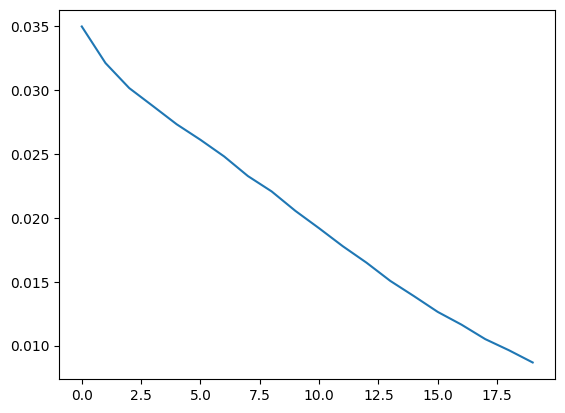

In [136]:
plt.plot(training_loss)

# inference


In [137]:
model.eval()
with torch.no_grad():
    running_hit = 0.0

    for text, label in tqdm(train_iter):
        text = text.cuda()
        label = label.cuda()

        output = model(text)

        pred = output.argmax(dim=1)
        pred = torch.sum(pred == label)
        running_hit += pred.item()

    print(running_hit / len(train_data))

100%|██████████| 11/11 [00:00<00:00, 101.58it/s]

1.0


In [138]:
model.eval()
with torch.no_grad():
    running_hit = 0.0

    for text, label in tqdm(test_iter):
        text = text.cuda()
        label = label.cuda()

        output = model(text)

        pred = output.argmax(dim=1)
        pred = torch.sum(pred == label)
        running_hit += pred.item()

    print(running_hit / len(test_data))

100%|██████████| 3/3 [00:00<00:00, 104.21it/s]

0.6627906976744186


In [77]:
model_path = artifacts_path.joinpath("textcnn.pth")

In [78]:
torch.save(model.state_dict(), model_path)

In [79]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>